# House Price Prediction Using Artificial Neural Network (ANN)

**Author:** Shravan  
**Purpose:** End-to-end House price prediction system  
**Framework:** TensorFlow/Keras  

---

## Overview
This notebook demonstrates how to:
1. Fetch real-time stock data
2. Engineer relevant features
3. Build and train an ANN model
4. Evaluate performance
5. Make future predictions

**⚠️ Disclaimer:** This is for educational purposes only. Past performance does not guarantee future results.

## Step 1: Install and Import Required Libraries

In [ ]:
# Install required packages
!pip install yfinance scikit-learn pandas numpy matplotlib seaborn tensorflow -q

print("✓ All packages installed successfully!")

✓ All packages installed successfully!


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder ##Added for encoding City
from tensorflow.keras.layers import Input, Embedding, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {keras.__version__}")

✓ All libraries imported successfully!
TensorFlow version: 3.10.0


## Step 2: Configuration and Data Collection

In [ ]:
df = pd.read_csv("/content/house_price_india_nn_dataset.csv")

# Flatten MultiIndex columns if they exist
# yfinance can return columns like ('Close', 'AAPL') or just 'Close' depending on version/arguments
if isinstance(df.columns, pd.MultiIndex):
    # Ensure all columns are single-level strings like 'Close', 'Volume'
    # This typically drops the second level (e.g., 'AAPL' from ('Close', 'AAPL'))
    print("MultiIndex")
    df.columns = df.columns.droplevel(1)

print(f"✓ Successfully downloaded {len(df)} days of data")
print(f"  Columns: {list(df.columns)}")

# Display basic information
print("\n" + "="*60)
print("DATA PREVIEW")
print("="*60)
df.head(10)

✓ Successfully downloaded 5000 days of data
  Columns: ['Area_sqft', 'Bedrooms', 'Bathrooms', 'Floors', 'Age_years', 'Location_Score', 'Distance_to_City_km', 'Garage', 'Parking_Count', 'Lift', 'Power_Backup', 'Swimming_Pool', 'Gym', 'Garden', 'Gated_Community', 'City', 'Metro_City', 'Price_INR']

DATA PREVIEW


,Area_sqft,Bedrooms,Bathrooms,Floors,Age_years,Location_Score,Distance_to_City_km,Garage,Parking_Count,Lift,Power_Backup,Swimming_Pool,Gym,Garden,Gated_Community,City,Metro_City,Price_INR
0,3674,3,1,2,20,2.290768,1.433251,0,2,0,0,1,0,0,1,Ahmedabad,0,19551314
1,1360,2,2,3,19,2.509700,27.845720,1,3,0,1,1,1,1,1,Chennai,1,11570646
2,1794,1,1,2,22,1.410153,21.210896,0,0,0,0,1,1,0,0,Jaipur,0,7839966
3,1630,1,4,3,3,9.119388,12.713824,1,2,0,1,0,1,1,1,Hyderabad,1,16559910
4,1595,3,4,2,20,5.866914,18.152179,0,2,1,1,0,0,1,0,Ahmedabad,0,10903140
5,3592,2,3,1,20,7.299635,13.178358,1,3,0,0,0,1,0,1,Coimbatore,0,17658337
6,2138,1,4,3,0,8.452977,14.227507,1,0,0,1,0,1,0,1,Bengaluru,1,21102724
7,2669,1,1,1,14,8.123869,26.660891,0,0,0,1,1,0,1,1,Ahmedabad,0,15683948
8,966,4,1,2,16,8.943451,5.251985,0,2,1,0,1,0,1,0,Jaipur,0,8828218
9,1738,4,4,2,13,9.705292,3.558239,0,1,0,0,1,0,1,0,Hyderabad,1,16583369


In [ ]:
# Basic statistics
print("\nBasic Statistics:")
df.describe()


Basic Statistics:


,Area_sqft,Bedrooms,Bathrooms,Floors,Age_years,Location_Score,Distance_to_City_km,Garage,Parking_Count,Lift,...,Gym,Garden,Gated_Community,Metro_City,Price_INR,Bath_Per_Bed,Living_Density,Amenity_Count,Elevator_Necessity,City_ID
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2272.444600,2.985000,2.494000,2.001600,19.331000,5.591855,15.403130,0.504200,1.485200,0.498200,...,0.504400,0.503000,0.510400,0.501800,1.668315e+07,1.139970,0.001749,5.004000,0.670200,4.559400
std,1005.817287,1.412648,1.130584,0.813222,11.546086,2.600681,8.432416,0.500032,1.127136,0.500047,...,0.500031,0.500041,0.499942,0.500047,7.124678e+06,0.940576,0.001510,1.718189,0.470187,2.885435
min,500.000000,1.000000,1.000000,1.000000,0.000000,1.005505,0.501420,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.838854e+06,0.200000,0.000251,0.000000,0.000000,0.000000
25%,1413.750000,2.000000,1.000000,1.000000,9.000000,3.391787,8.149628,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.122169e+07,0.500000,0.000774,4.000000,0.000000,2.000000
50%,2287.000000,3.000000,3.000000,2.000000,19.000000,5.638586,15.412782,1.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.583630e+07,1.000000,0.001314,5.000000,1.000000,5.000000
75%,3145.000000,4.000000,4.000000,3.000000,30.000000,7.796670,22.531548,1.000000,3.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.110071e+07,1.500000,0.002146,6.000000,1.000000,7.000000
max,3999.000000,5.000000,4.000000,3.000000,39.000000,9.999109,29.989861,1.000000,3.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,4.091534e+07,4.000000,0.009921,10.000000,1.000000,9.000000


## Step 3: Feature Engineering

In [ ]:
# Create technical indicators
print("Creating technical indicators...")

# Bathrooms Per Bedroom  Strong luxury indicator
df['Bath_Per_Bed'] = df['Bathrooms'] / df['Bedrooms']
# Is_New_House -- Helps NN learn age-based price plateaus
df['Is_New_House'] = df['Age_years'] <= 5
# Living Density - Captures overcrowding effect.
df['Living_Density'] = df['Bedrooms'] / df['Area_sqft']
#Amenity Count - Luxury Strength Signal
df['Amenity_Count'] = df['Parking_Count'] + df['Swimming_Pool'] + df['Gym'] + df['Lift'] + df['Garden'] + df['Garage'] + df['Power_Backup'] + df['Gated_Community']
#Elevator Necessity Flag
df['Elevator_Necessity'] = (df['Floors'] >= 2).astype(int)

print("✓ Technical indicators created")
df.head(10)

Creating technical indicators...
✓ Technical indicators created


,Area_sqft,Bedrooms,Bathrooms,Floors,Age_years,Location_Score,Distance_to_City_km,Garage,Parking_Count,Lift,...,Garden,Gated_Community,City,Metro_City,Price_INR,Bath_Per_Bed,Is_New_House,Living_Density,Amenity_Count,Elevator_Necessity
0,3674,3,1,2,20,2.290768,1.433251,0,2,0,...,0,1,Ahmedabad,0,19551314,0.333333,False,0.000817,4,1
1,1360,2,2,3,19,2.509700,27.845720,1,3,0,...,1,1,Chennai,1,11570646,1.000000,False,0.001471,9,1
2,1794,1,1,2,22,1.410153,21.210896,0,0,0,...,0,0,Jaipur,0,7839966,1.000000,False,0.000557,2,1
3,1630,1,4,3,3,9.119388,12.713824,1,2,0,...,1,1,Hyderabad,1,16559910,4.000000,True,0.000613,7,1
4,1595,3,4,2,20,5.866914,18.152179,0,2,1,...,1,0,Ahmedabad,0,10903140,1.333333,False,0.001881,5,1
5,3592,2,3,1,20,7.299635,13.178358,1,3,0,...,0,1,Coimbatore,0,17658337,1.500000,False,0.000557,6,0
6,2138,1,4,3,0,8.452977,14.227507,1,0,0,...,0,1,Bengaluru,1,21102724,4.000000,True,0.000468,4,1
7,2669,1,1,1,14,8.123869,26.660891,0,0,0,...,1,1,Ahmedabad,0,15683948,1.000000,False,0.000375,4,0
8,966,4,1,2,16,8.943451,5.251985,0,2,1,...,1,0,Jaipur,0,8828218,0.250000,False,0.004141,5,1
9,1738,4,4,2,13,9.705292,3.558239,0,1,0,...,1,0,Hyderabad,1,16583369,1.000000,False,0.002301,3,1


In [ ]:
num_cities = df["City"].nunique()
num_cities


10

In [ ]:
city_encoder = LabelEncoder()

In [ ]:
df["City"]

,City
0,Ahmedabad
1,Chennai
2,Jaipur
3,Hyderabad
4,Ahmedabad
...,...
4995,Ahmedabad
4996,Chennai
4997,Hyderabad
4998,Bengaluru


In [ ]:
df['City_ID'] = city_encoder.fit_transform(df["City"])

In [ ]:
df['City_ID']

,City_ID
0,0
1,2
2,7
3,5
4,0
...,...
4995,0
4996,2
4997,5
4998,1


In [ ]:
city_input = Input(shape=(1,), name="City_Input")

In [ ]:
print(city_input)

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=City_Input>


In [ ]:
city_embedding = Embedding( input_dim=num_cities, output_dim=3, name="City_Embedding" )(city_input)

In [ ]:
city_embedding

<KerasTensor shape=(None, 1, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_2>

In [ ]:
# Convert City to Embedding for the MinMaxScaler to work
num_cities = df["City"].nunique()
print(f"Number of unique cities: {num_cities}")
city_encoder = LabelEncoder()
df['City_ID'] = city_encoder.fit_transform(df["City"])
city_input = Input(shape=(1,), name="City_Input")
city_embedding = Embedding( input_dim=num_cities, output_dim=3, name="City_Embedding" )(city_input)
print(f"Before Flattening : {city_embedding.shape}")
city_embedding = Flatten()(city_embedding)
print(f"After Flattening : {city_embedding.shape}")

Number of unique cities: 10
Before Flattening : (None, 1, 3)
After Flattening : (None, 3)


In [ ]:
# Remove NaN values
df_clean = df.dropna()
df_clean['Predicted_Price'] = df['Price_INR']
print(f"\n✓ Feature engineering complete!")
print(f"  Total features: {len(df_clean.columns)}")
print(f"  Clean dataset shape: {df_clean.shape}")
print(f"  Rows removed (NaN): {len(df) - len(df_clean)}")

# Show all features
print("\nAll Features:")
print(list(df_clean.columns))


✓ Feature engineering complete!
  Total features: 25
  Clean dataset shape: (5000, 25)
  Rows removed (NaN): 0

All Features:
['Area_sqft', 'Bedrooms', 'Bathrooms', 'Floors', 'Age_years', 'Location_Score', 'Distance_to_City_km', 'Garage', 'Parking_Count', 'Lift', 'Power_Backup', 'Swimming_Pool', 'Gym', 'Garden', 'Gated_Community', 'City', 'Metro_City', 'Price_INR', 'Bath_Per_Bed', 'Is_New_House', 'Living_Density', 'Amenity_Count', 'Elevator_Necessity', 'City_ID', 'Predicted_Price']


## Step 4: Data Preparation for Training

In [ ]:
# Select features for training
feature_cols = [
    'Area_sqft', 'Bedrooms', 'Bathrooms', 'Floors', 'Age_years', 'Location_Score', 'Distance_to_City_km', 'Garage', 'Parking_Count', 'Lift', 'Power_Backup', 'Swimming_Pool', 'Gym', 'Garden', 'Gated_Community', 'Metro_City', 'Price_INR', 'Bath_Per_Bed', 'Is_New_House', 'Living_Density', 'Amenity_Count', 'Elevator_Necessity','City_ID'
]

X = df_clean[feature_cols].values
y = df_clean['Predicted_Price'].values

print("Data Preparation:")
print(f"  Features (X) shape: {X.shape}")
print(f"  Target (y) shape: {y.shape}")
print(f"  Number of features: {len(feature_cols)}")

Data Preparation:
  Features (X) shape: (5000, 23)
  Target (y) shape: (5000,)
  Number of features: 23


In [ ]:
# Split data: 80% training, 20% testing
# Important: shuffle=False to maintain time series order
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True
)

print("\nData Split:")
print(f"  Training samples: {X_train.shape[0]} ({(X_train.shape[0]/X.shape[0])*100:.1f}%)")
print(f"  Testing samples: {X_test.shape[0]} ({(X_test.shape[0]/X.shape[0])*100:.1f}%)")


Data Split:
  Training samples: 4000 (80.0%)
  Testing samples: 1000 (20.0%)


In [ ]:
# Feature Scaling (Normalization)
print("\nScaling features...")

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit on training data and transform both train and test
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

print("✓ Features normalized using MinMaxScaler (0 to 1)")
print(f"  X_train_scaled range: [{X_train_scaled.min():.4f}, {X_train_scaled.max():.4f}]")
print(f"  y_train_scaled range: [{y_train_scaled.min():.4f}, {y_train_scaled.max():.4f}]")


Scaling features...
✓ Features normalized using MinMaxScaler (0 to 1)
  X_train_scaled range: [0.0000, 1.0000]
  y_train_scaled range: [0.0000, 1.0000]


In [ ]:
input_shape=(X_train_scaled.shape[1],)
input_shape

(23,)

In [ ]:
X.shape

(5000, 23)

## Step 5: Build Artificial Neural Network (ANN) Model

In [ ]:
# Build ANN architecture
print("Building Neural Network Architecture...\n")

model = Sequential([
    # Input Layer + First Hidden Layer
    Dense(23, activation='relu', input_shape=(X_train_scaled.shape[1],), name='Input_Layer'),
    Dropout(0.2, name='Dropout_1'),

    # Second Hidden Layer
    Dense(64, activation='relu', name='Hidden_Layer_1'),
    Dropout(0.2, name='Dropout_2'),

    # Third Hidden Layer
    Dense(32, activation='relu', name='Hidden_Layer_2'),
    Dropout(0.1, name='Dropout_3'),

    # Fourth Hidden Layer
    Dense(16, activation='relu', name='Hidden_Layer_3'),

    # Output Layer (Regression)
    Dense(1, name='Output_Layer')
])

print("✓ Model architecture created!")
print("\nModel Summary:")
model.summary()

Building Neural Network Architecture...

✓ Model architecture created!

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (Dense)             │ (None, 23)             │           552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_1 (Dense)          │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_3 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,713 (18.41 KB)

 Trainable params: 4,713 (18.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error for regression
    metrics=['mae']  # Mean Absolute Error
)

print("✓ Model compiled successfully!")
print("  Optimizer: Adam")
print("  Loss Function: Mean Squared Error (MSE)")
print("  Metrics: Mean Absolute Error (MAE)")

✓ Model compiled successfully!
  Optimizer: Adam
  Loss Function: Mean Squared Error (MSE)
  Metrics: Mean Absolute Error (MAE)


## Step 6: Train the Model

In [ ]:
# Setup callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

print("Training Configuration:")
print("  Epochs: 100")
print("  Batch Size: 32")
print("  Validation Split: 20%")
print("  Early Stopping: Enabled (patience=15)")
print("\nStarting training...\n")

Training Configuration:
  Epochs: 100
  Batch Size: 32
  Validation Split: 20%
  Early Stopping: Enabled (patience=15)

Starting training...



In [ ]:
# Train the model
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print("\n✓ Training completed!")

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1164 - mae: 0.2674 - val_loss: 0.0275 - val_mae: 0.1292
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0293 - mae: 0.1355 - val_loss: 0.0170 - val_mae: 0.1011
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199 - mae: 0.1118 - val_loss: 0.0116 - val_mae: 0.0816
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150 - mae: 0.0951 - val_loss: 0.0088 - val_mae: 0.0712
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - mae: 0.0821 - val_loss: 0.0093 - val_mae: 0.0738
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - mae: 0.0748 - val_loss: 0.0070 - val_mae: 0.0639
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 - mae: 0.0729 - val_loss: 0.0093 - val_mae: 0.0744
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - mae: 0.0668 - val_loss: 0.0095 - val_mae: 0.0745
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

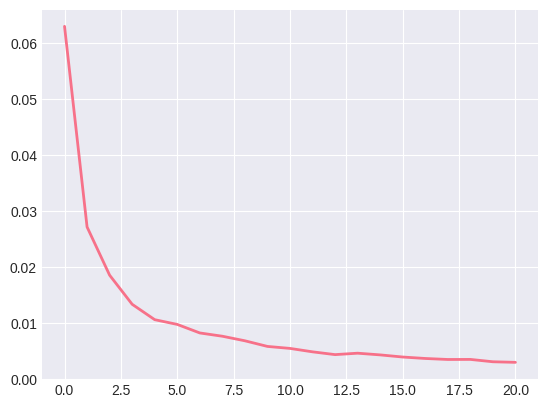

In [ ]:
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)

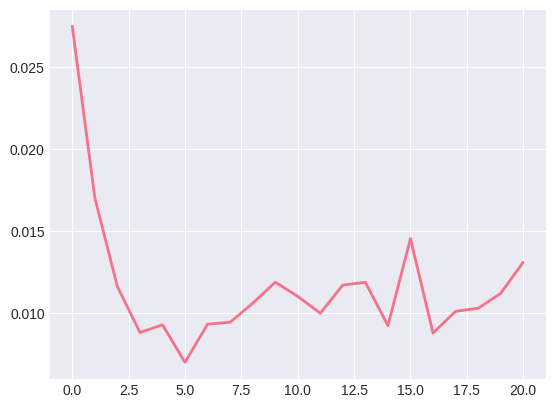

In [ ]:
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)

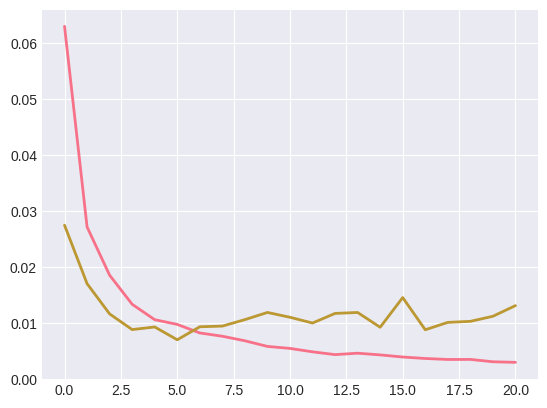

In [ ]:
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)

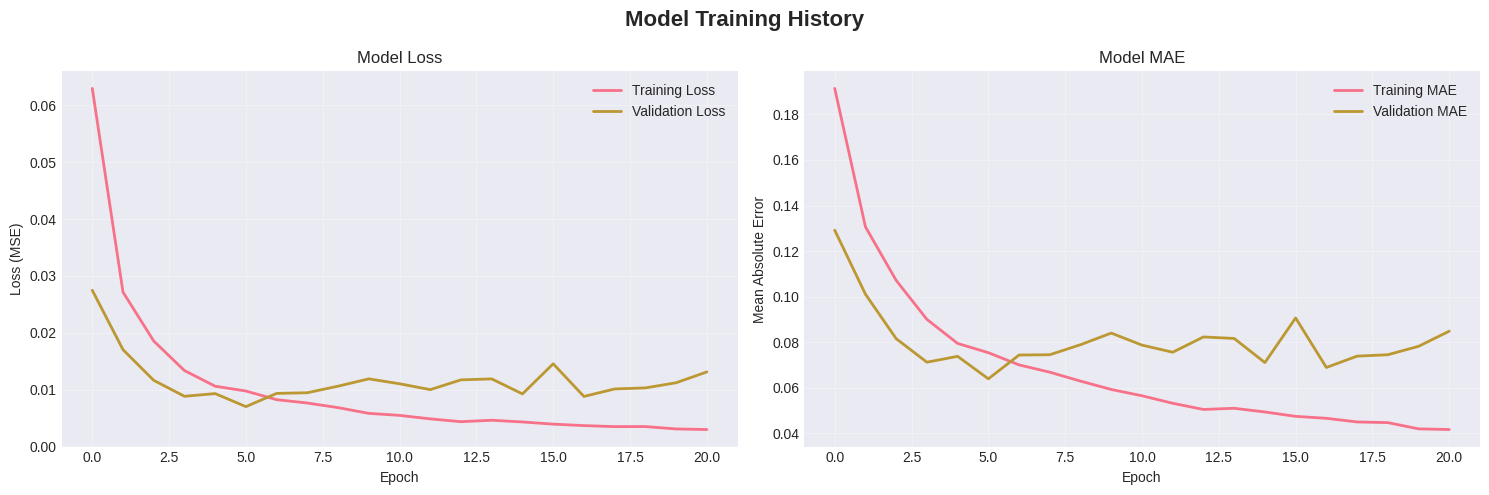


Final Metrics:
  Training Loss: 0.002978
  Validation Loss: 0.013109
  Training MAE: 0.041682
  Validation MAE: 0.084868


In [ ]:
# Visualize training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Model Training History', fontsize=16, fontweight='bold')

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE plot
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Model MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Metrics:")
print(f"  Training Loss: {history.history['loss'][-1]:.6f}")
print(f"  Validation Loss: {history.history['val_loss'][-1]:.6f}")
print(f"  Training MAE: {history.history['mae'][-1]:.6f}")
print(f"  Validation MAE: {history.history['val_mae'][-1]:.6f}")

## Step 7: Model Evaluation and Predictions

In [ ]:
# Make predictions on test set
print("Making predictions on test data...\n")

y_pred_scaled = model.predict(X_test_scaled, verbose=0)

# Inverse transform to get actual prices
y_pred = scaler_y.inverse_transform(y_pred_scaled)

print("✓ Predictions completed!")
print(f"  Predictions shape: {y_pred.shape}")

Making predictions on test data...

✓ Predictions completed!
  Predictions shape: (1000, 1)


In [ ]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100

print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print(f"Mean Squared Error (MSE):        ${mse:.2f}")
print(f"Root Mean Squared Error (RMSE):  ${rmse:.2f}")
print(f"Mean Absolute Error (MAE):       ${mae:.2f}")
print(f"Mean Absolute Percentage Error:  {mape:.2f}%")
print(f"R² Score:                        {r2:.4f} ({r2*100:.2f}%)")
print("="*60)

# Interpretation
print("\nInterpretation:")
if r2 > 0.9:
    print("  🟢 Excellent model performance!")
elif r2 > 0.8:
    print("  🟢 Good model performance")
elif r2 > 0.7:
    print("  🟡 Moderate model performance")
else:
    print("  🔴 Model needs improvement")

print(f"  Average prediction error: ${mae:.2f} per share ({mape:.2f}%)")

MODEL PERFORMANCE METRICS
Mean Squared Error (MSE):        $8751446753280.00
Root Mean Squared Error (RMSE):  $2958284.43
Mean Absolute Error (MAE):       $2264187.25
Mean Absolute Percentage Error:  14.28%
R² Score:                        0.8230 (82.30%)

Interpretation:
  🟢 Good model performance
  Average prediction error: $2264187.25 per share (14.28%)


In [ ]:
[y_test.min(), y_test.max()], [y_test.min(), y_test.max()]

([np.int64(3232787), np.int64(40915336)],
 [np.int64(3232787), np.int64(40915336)])

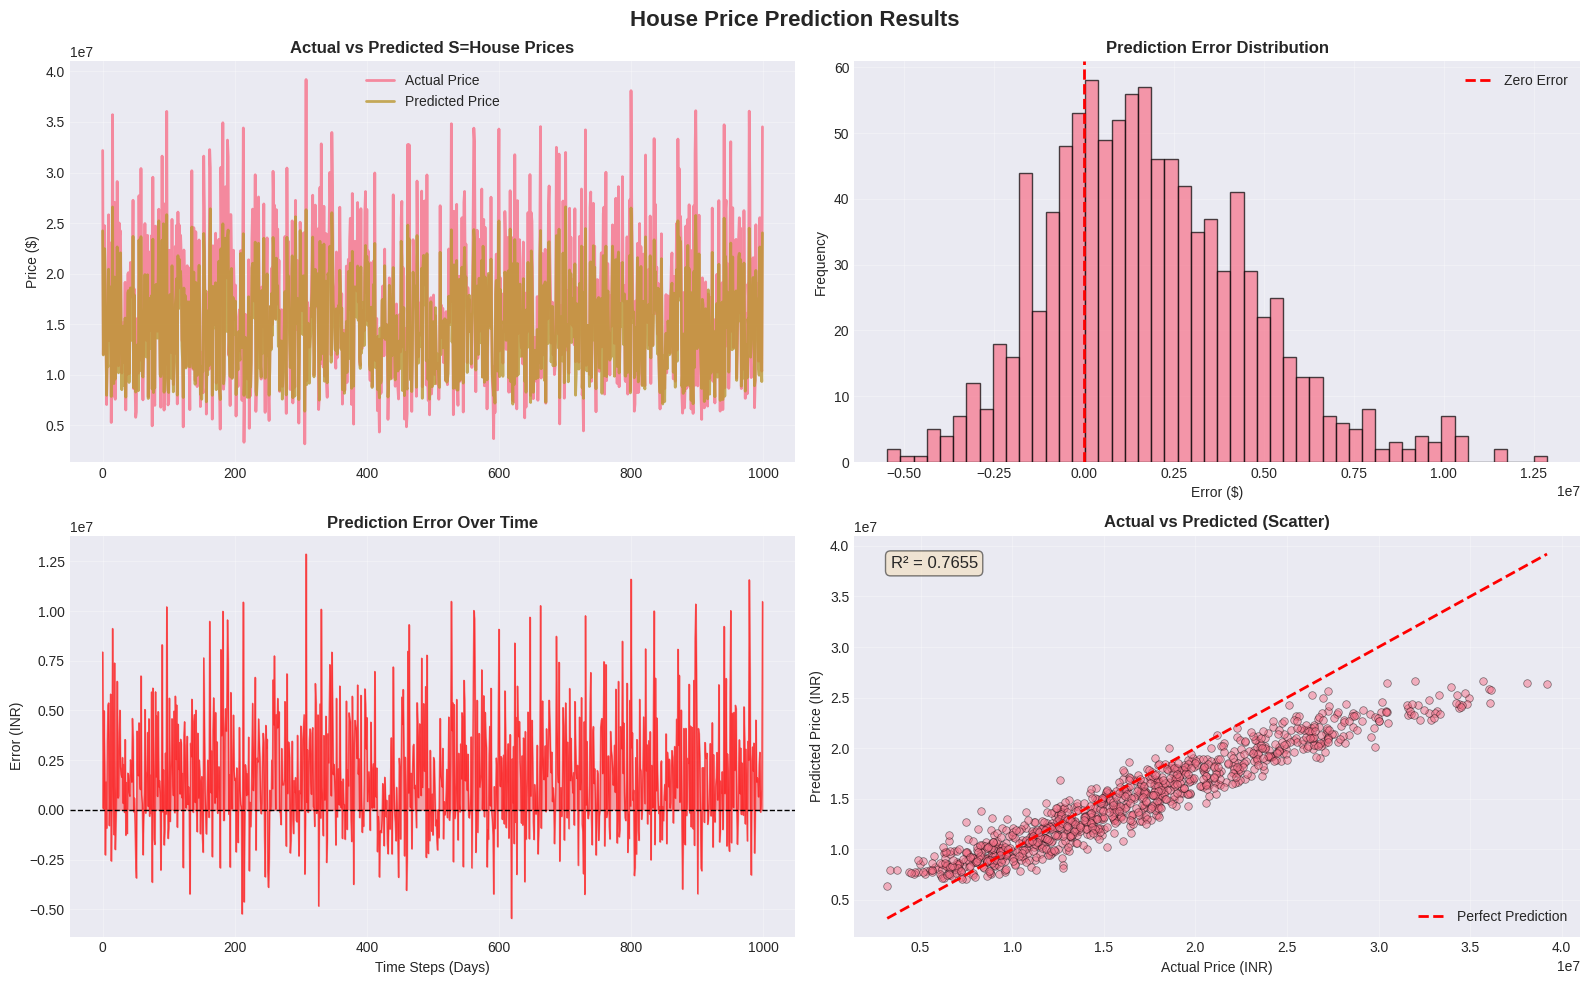

In [ ]:
# Comprehensive visualization of results
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f'House Price Prediction Results', fontsize=16, fontweight='bold')

# Plot 1: Actual vs Predicted Prices
axes[0, 0].plot(y_test, label='Actual Price', linewidth=2, alpha=0.8)
axes[0, 0].plot(y_pred, label='Predicted Price', linewidth=2, alpha=0.8)
axes[0, 0].set_title('Actual vs Predicted S=House Prices', fontweight='bold')
#axes[0, 0].set_xlabel('Time Steps (Days)')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Prediction Error Distribution
error = y_test - y_pred.flatten()
axes[0, 1].hist(error, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 1].set_title('Prediction Error Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Error ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Error Over Time
axes[1, 0].plot(error, color='red', alpha=0.6, linewidth=1)
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].fill_between(range(len(error)), error, 0, alpha=0.3, color='red')
axes[1, 0].set_title('Prediction Error Over Time', fontweight='bold')
axes[1, 0].set_xlabel('Time Steps (Days)')
axes[1, 0].set_ylabel('Error (INR)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Scatter Plot - Actual vs Predicted
axes[1, 1].scatter(y_test, y_pred, alpha=0.5, s=30, edgecolors='k', linewidth=0.5)
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_title('Actual vs Predicted (Scatter)', fontweight='bold')
axes[1, 1].set_xlabel('Actual Price (INR)')
axes[1, 1].set_ylabel('Predicted Price (INR)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Add R² score as text
axes[1, 1].text(0.05, 0.95, f'R² = {r2:.4f}',
                transform=axes[1, 1].transAxes,
                fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## Step 8: Future Price Prediction

In [ ]:
# Predict next day's price using the most recent data
print("="*60)
print("NEXT DAY PRICE PREDICTION")
print("="*60)

# Use the last available data point
last_data = X_test_scaled[-1].reshape(1, -1)

# Make prediction
next_day_pred_scaled = model.predict(last_data, verbose=0)
next_day_pred = scaler_y.inverse_transform(next_day_pred_scaled)

# Calculate change
last_price = y_test[-1]
predicted_price = next_day_pred[0][0]
price_change = predicted_price - last_price
percent_change = (price_change / last_price) * 100

print(f"\nLast Known Closing Price:  ${last_price:.2f}")
print(f"Predicted Next Day Price:  ${predicted_price:.2f}")
print(f"Expected Change:           ${price_change:.2f}")
print(f"Percentage Change:         {percent_change:+.2f}%")

print("="*60)

NEXT DAY PRICE PREDICTION

Last Known Closing Price:  $10182883.00
Predicted Next Day Price:  $9055647.00
Expected Change:           $-1127236.00
Percentage Change:         -11.07%


In [ ]:
# Show last 10 predictions vs actuals
print("\nLast 10 Predictions vs Actual Prices:")
print("="*60)

comparison_df = pd.DataFrame({
    'Actual Price': y_test[-10:],
    'Predicted Price': y_pred[-10:].flatten(),
    'Error': y_test[-10:] - y_pred[-10:].flatten(),
    'Error %': ((y_test[-10:] - y_pred[-10:].flatten()) / y_test[-10:] * 100)
})

comparison_df.index = range(len(comparison_df), 0, -1)
comparison_df.index.name = 'Days Ago'

print(comparison_df.to_string())
print("="*60)


Last 10 Predictions vs Actual Prices:
          Actual Price  Predicted Price      Error    Error %
Days Ago                                                     
10          249.909714       194.507248  55.402466  22.168993
9           252.338730       195.583054  56.755676  22.491861
8           246.933182       195.274292  51.658890  20.920190
7           248.665344       196.363693  52.301651  21.032947
6           253.344208       195.984924  57.359283  22.640851
5           254.120697       197.629059  56.491638  22.230239
4           257.037506       197.260910  59.776596  23.255982
3           257.853760       195.604156  62.249603  24.141437
2           254.439224       202.094727  52.344498  20.572495
1           251.064484       201.475845  49.588638  19.751355


## Step 9: Save Model and Scalers

In [ ]:
import pickle

# Save the model
model_filename = f'{TICKER}_stock_prediction_ann.h5'
model.save(model_filename)
print(f"✓ Model saved as: {model_filename}")

# Save scalers
with open(f'{TICKER}_scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)

with open(f'{TICKER}_scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

print(f"✓ Scalers saved as: {TICKER}_scaler_X.pkl and {TICKER}_scaler_y.pkl")

# Save feature names
with open(f'{TICKER}_feature_names.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

print(f"✓ Feature names saved as: {TICKER}_feature_names.pkl")
print("\n✅ All artifacts saved successfully!")

✓ Model saved as: AAPL_stock_prediction_ann.h5
✓ Scalers saved as: AAPL_scaler_X.pkl and AAPL_scaler_y.pkl
✓ Feature names saved as: AAPL_feature_names.pkl

✅ All artifacts saved successfully!


## Step 10: Model Summary and Recommendations

In [ ]:
print("="*60)
print("MODEL SUMMARY AND RECOMMENDATIONS")
print("="*60)

print(f"\n📊 Model Performance:")
print(f"   R² Score: {r2:.4f} ({r2*100:.2f}%)")
print(f"   Average Error: ${mae:.2f} ({mape:.2f}%)")

print(f"\n🎯 Training Details:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Test samples: {X_test.shape[0]}")
print(f"   Number of features: {len(feature_cols)}")
print(f"   Epochs trained: {len(history.history['loss'])}")

print(f"\n💡 Recommendations:")
print(f"   1. This model is for educational purposes only")
print(f"   2. Always use multiple indicators for trading decisions")
print(f"   3. Consider fundamental analysis alongside technical indicators")
print(f"   4. Implement proper risk management strategies")
print(f"   5. Backtest thoroughly before any real trading")

print(f"\n🔄 To improve the model:")
print(f"   - Add more features (sentiment analysis, news data)")
print(f"   - Try LSTM/GRU layers for better sequence modeling")
print(f"   - Experiment with different architectures")
print(f"   - Use ensemble methods (combine multiple models)")
print(f"   - Tune hyperparameters systematically")

print("\n" + "="*60)
print("✅ ANALYSIS COMPLETE!")
print("="*60)

MODEL SUMMARY AND RECOMMENDATIONS

📊 Model Performance:
   R² Score: -1.3035 (-130.35%)
   Average Error: $37.29 (17.77%)

🎯 Training Details:
   Training samples: 981
   Test samples: 246
   Number of features: 23
   Epochs trained: 16

💡 Recommendations:
   1. This model is for educational purposes only
   2. Always use multiple indicators for trading decisions
   3. Consider fundamental analysis alongside technical indicators
   4. Implement proper risk management strategies
   5. Backtest thoroughly before any real trading

🔄 To improve the model:
   - Add more features (sentiment analysis, news data)
   - Try LSTM/GRU layers for better sequence modeling
   - Experiment with different architectures
   - Use ensemble methods (combine multiple models)
   - Tune hyperparameters systematically

✅ ANALYSIS COMPLETE!
